# Project Code

## Import libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

import cufflinks as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots

%matplotlib inline

## Read data and visualization

In [7]:
df = pd.read_csv("Dataset_heart.csv")
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [4]:
# find out the categorical & numerical columns
numerical = df.drop(["HeartDisease"], axis=1).select_dtypes("number").columns
categorical = df.select_dtypes("object").columns
df[categorical].nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

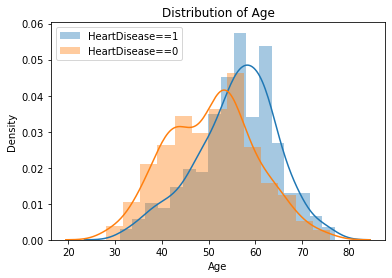

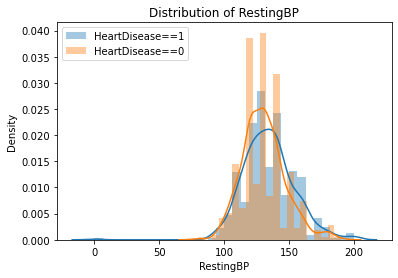

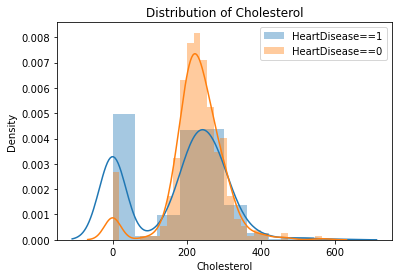

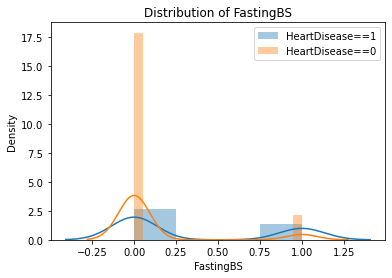

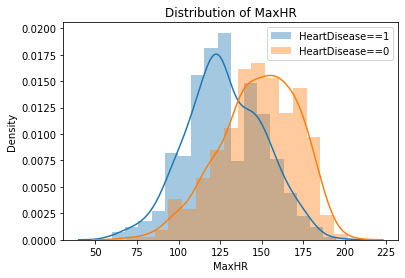

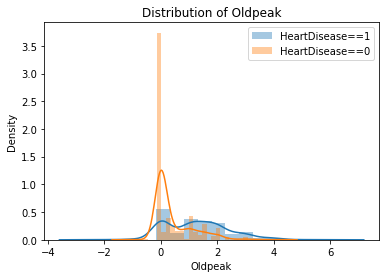

In [5]:
# Histograms for each feature
for var in numerical:
    df_1 = df.loc[df.HeartDisease == 1]
    df_0 = df.loc[df.HeartDisease == 0]
    sns.distplot(a=df_1[var], label="HeartDisease==1")
    sns.distplot(a=df_0[var], label="HeartDisease==0")
    plt.title("Distribution of" + " " + var)
    plt.legend()
    plt.show()

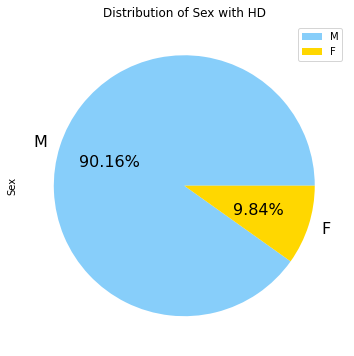

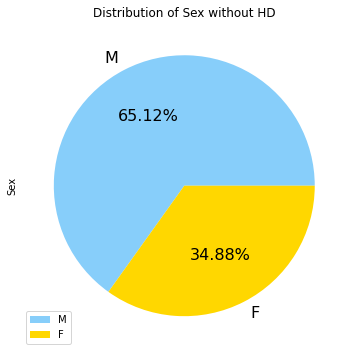

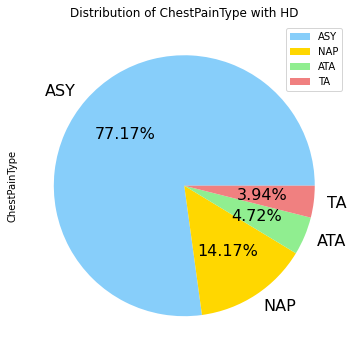

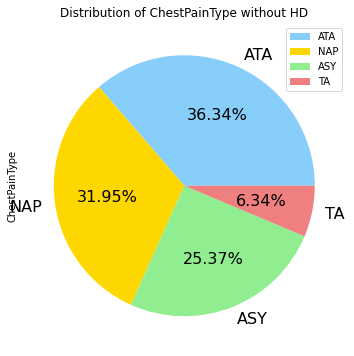

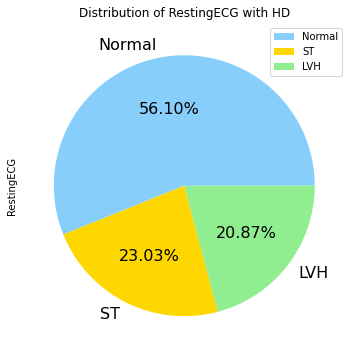

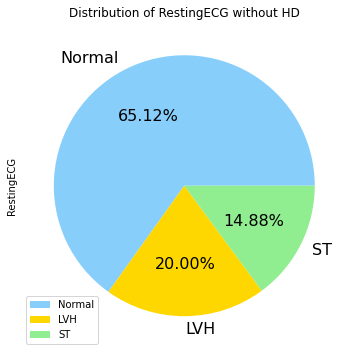

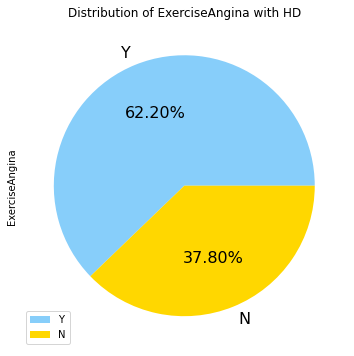

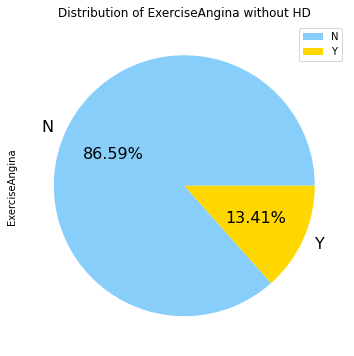

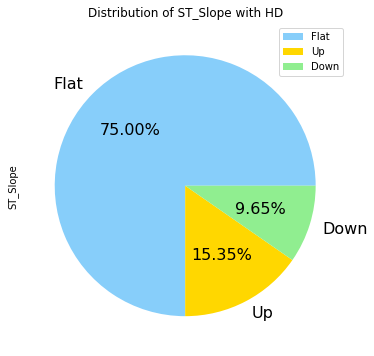

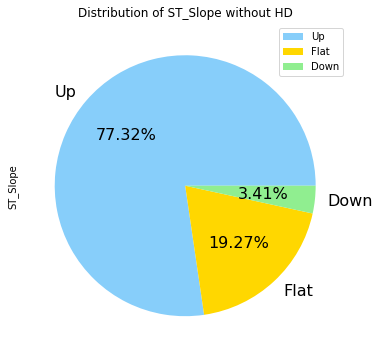

In [6]:
# Draw pie charts for categorical features
for var in categorical:
    df_1 = df.loc[df.HeartDisease == 1]
    df_0 = df.loc[df.HeartDisease == 0]
    df_1[var].value_counts().plot.pie(
        colors=["lightskyblue", "gold", "lightgreen", "lightcoral"],
        autopct="%.2f%%",
        fontsize=16,
        figsize=(6, 6),
    )
    plt.title("Distribution of" + " " + var + " with HD")
    plt.legend(loc="best")
    plt.show()
    df_0[var].value_counts().plot.pie(
        colors=["lightskyblue", "gold", "lightgreen", "lightcoral"],
        autopct="%.2f%%",
        fontsize=16,
        figsize=(6, 6),
    )
    plt.title("Distribution of" + " " + var + " without HD")
    plt.legend(loc="best")
    plt.show()

## Data cleaning

In [8]:
# No duplicated values
df.duplicated().sum()

0

In [9]:
# No missing values
missing_number = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_values = pd.concat(
    [missing_number, missing_percent],
    axis=1,
    keys=["Missing_Number", "Missing_Percent"],
)
missing_values

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


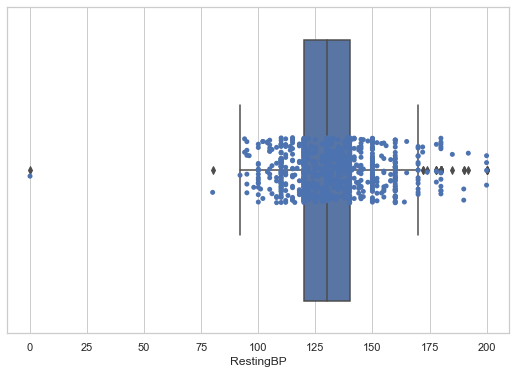

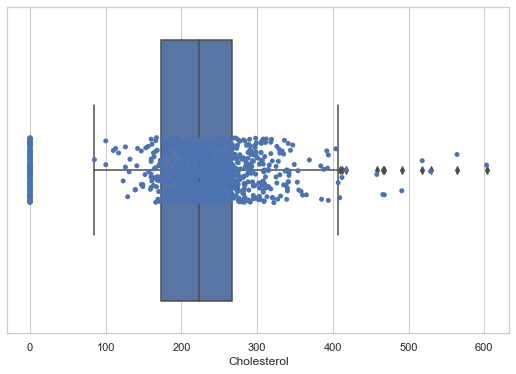

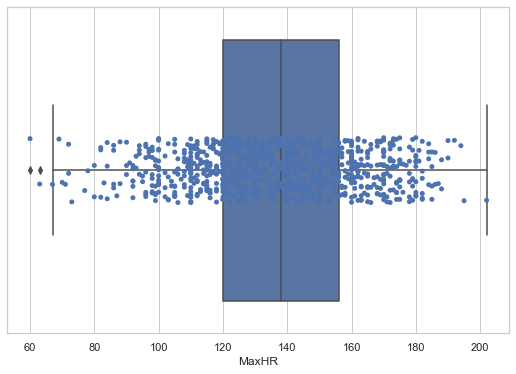

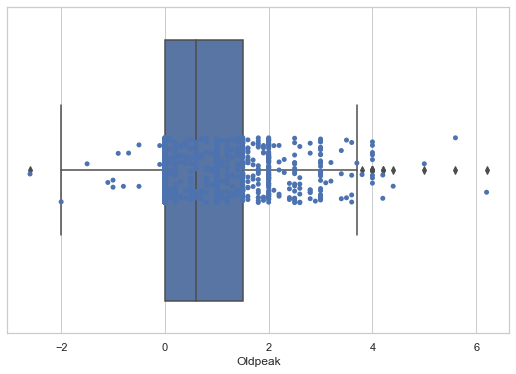

In [10]:
# Draw boxplot for categorical features
col2 = ["RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
sns.set_theme(style="whitegrid")
for c in col2:
    fig = plt.figure(figsize=(9, 6))
    sns.boxplot(x=df[c], hue=df.HeartDisease)
    sns.stripplot(x=df[c], hue=df.HeartDisease)

In [11]:
# clean outliers for cholesterols
q1, q3 = np.percentile(df["Cholesterol"], [25, 75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
df = df[(df["Cholesterol"] >= lower_bound) & (df["Cholesterol"] <= upper_bound)]

## Method

### Bayes classifier

In [14]:
X = df.drop(["HeartDisease"], axis=1)
y = df["HeartDisease"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [15]:
# encode remaining variables with one-hot encoding
import category_encoders as ce

encoder = ce.OneHotEncoder(
    cols=["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
cols = X_train.columns
from sklearn.preprocessing import RobustScaler # Use robustscaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [16]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score

print("Training set score: {:.4f}".format(gnb.score(X_train, y_train)))
print("Test set score: {:.4f}".format(gnb.score(X_test, y_test)))

Training set score: 0.8560
Test set score: 0.8688


<AxesSubplot:>

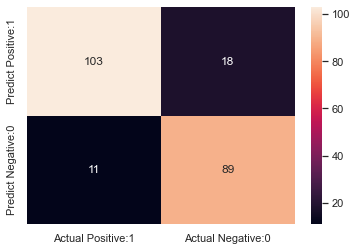

In [18]:
# Print the Confusion Matrix and slice it into four pieces
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(
    data=cm,
    columns=["Actual Positive:1", "Actual Negative:0"],
    index=["Predict Positive:1", "Predict Negative:0"],
)
sns.heatmap(cm_matrix, annot=True, fmt="d")

In [19]:
TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
# print scores
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
precision = TP / float(TP + FP)
specificity = TN / (TN + FP)
print("Classification accuracy : {0:0.4f}".format(classification_accuracy))
print("Precision : {0:0.4f}".format(precision))
print("Specificity : {0:0.4f}".format(specificity))
# store the predicted probabilities for class
y_pred1 = gnb.predict_proba(X_test)[:, 1]

Classification accuracy : 0.8688
Precision : 0.8512
Specificity : 0.8318


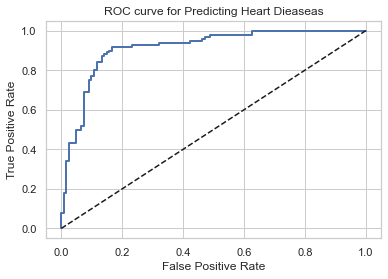

In [20]:
# plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label=1)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.rcParams["font.size"] = 12
plt.title("ROC curve for Predicting Heart Dieaseas")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [22]:
# compute ROC AUC
from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, y_pred1)
print("ROC AUC : {:.4f}".format(ROC_AUC))
# calculate cross-validated ROC AUC
from sklearn.model_selection import cross_val_score

Cross_validated_ROC_AUC = cross_val_score(
    gnb, X_train, y_train, cv=10, scoring="roc_auc"
).mean()
print("ROC AUC (after cv) : {:.4f}".format(Cross_validated_ROC_AUC))

ROC AUC : 0.9133
ROC AUC (after cv) : 0.9168


In [23]:
# Applying 10-Fold Cross Validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gnb, X_train, y_train, cv=10, scoring="accuracy")
# compute Average cross-validation score
print("Average cross-validation score: {:.4f}".format(scores.mean()))

Average cross-validation score: 0.8541


### Catboost

In [24]:
# catboost model
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_predict, train_test_split

accuracy = []
model_names = []


X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]
categorical_features_indices = np.append(np.where(X.dtypes == object)[0], 5) # filter out categorical features

# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# different catboost with different learning rate
pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
model1 = CatBoostClassifier(
    learning_rate=0.01,
    verbose=False,
    random_state=0,
    task_type="GPU",
    boosting_type="Ordered", # All set as ordered boosting mode
).fit(pool)
model2 = CatBoostClassifier(
    learning_rate=0.02,
    verbose=False,
    random_state=0,
    task_type="GPU",
    boosting_type="Ordered",
).fit(pool)
model3 = CatBoostClassifier(
    learning_rate=0.03,
    verbose=False,
    random_state=0,
    task_type="GPU",
    boosting_type="Ordered",
).fit(pool)
model4 = CatBoostClassifier(
    learning_rate=0.04,
    verbose=False,
    random_state=0,
    task_type="GPU",
    boosting_type="Ordered",
).fit(pool)
model5 = CatBoostClassifier(
    learning_rate=0.05,
    verbose=False,
    random_state=0,
    task_type="GPU",
    boosting_type="Ordered",
).fit(pool)

# test accuracy
accuracy = []
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)
y_pred4 = model4.predict(X_test)
y_pred5 = model5.predict(X_test)
accuracy.append(accuracy_score(y_test, y_pred1))
accuracy.append(accuracy_score(y_test, y_pred2))
accuracy.append(accuracy_score(y_test, y_pred3))
accuracy.append(accuracy_score(y_test, y_pred4))
accuracy.append(accuracy_score(y_test, y_pred5))
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05]
result = pd.DataFrame({"Accuracy": accuracy}, index=learning_rate)

In [25]:
result

,Accuracy
0.01,0.873303
0.02,0.891403
0.03,0.886878
0.04,0.891403
0.05,0.891403


Text(0, 0.5, 'test accuracy')

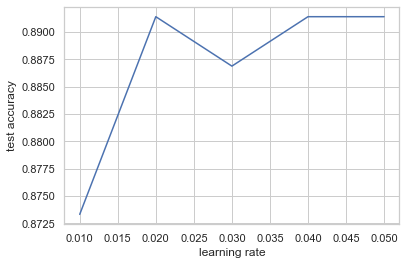

In [26]:
plt.plot(learning_rate, accuracy)
plt.xlabel("learning rate")
plt.ylabel("test accuracy")

<AxesSubplot:>

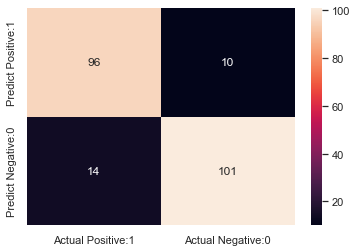

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred2)

cm_matrix = pd.DataFrame(
    data=cm,
    columns=["Actual Positive:1", "Actual Negative:0"],
    index=["Predict Positive:1", "Predict Negative:0"],
)
sns.heatmap(cm_matrix, annot=True, fmt="d")

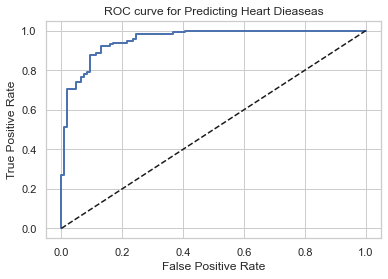

In [28]:
# Draw the ROC curve
from sklearn.metrics import roc_curve

y_pred2_ = model2.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred2_[:, 1], pos_label=1)

plt.figure(figsize=(6, 4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0, 1], [0, 1], "k--")

plt.rcParams["font.size"] = 12

plt.title("ROC curve for Predicting Heart Dieaseas")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Text(0, 0.5, 'train accuracy')

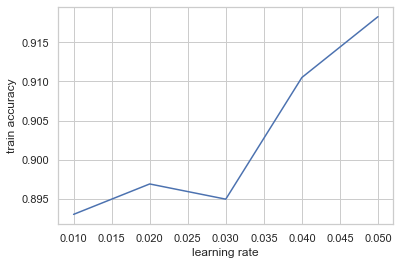

In [29]:
# train accuracy
accuracy_tr = []
y_pred1t = model1.predict(X_train)
y_pred2t = model2.predict(X_train)
y_pred3t = model3.predict(X_train)
y_pred4t = model4.predict(X_train)
y_pred5t = model5.predict(X_train)
accuracy_tr.append(accuracy_score(y_train, y_pred1t))
accuracy_tr.append(accuracy_score(y_train, y_pred2t))
accuracy_tr.append(accuracy_score(y_train, y_pred3t))
accuracy_tr.append(accuracy_score(y_train, y_pred4t))
accuracy_tr.append(accuracy_score(y_train, y_pred5t))
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05]
resultt = pd.DataFrame({"Accuracy": accuracy_tr}, index=learning_rate)

plt.plot(learning_rate, accuracy_tr)
plt.xlabel("learning rate")
plt.ylabel("train accuracy")

In [31]:
resultt

,Accuracy
0.01,0.892996
0.02,0.896887
0.03,0.894942
0.04,0.910506
0.05,0.918288


### Ensembles

In [33]:
# import libraries for ensembles with different models
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)

%matplotlib inline
# import opendatasets as od
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.svm import SVC

# from imblearn.over_sampling import SMOTE

In [2]:
categorical = df.select_dtypes("object").columns
#get the category of the dataset
accuracy = []
train_accuracy = []
model_names = []
#create an empty list for further usage

X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=49
)
#split the dataset into train dataset and test dataset

onehotencoder = OneHotEncoder()
c = make_column_transformer((onehotencoder, categorical), remainder="passthrough")

adaboost = AdaBoostClassifier(random_state=1)
gradientboost = GradientBoostingClassifier(random_state=1)
randomforest = RandomForestClassifier(random_state=1)
extratree = ExtraTreesClassifier(random_state=1)
# import the four esemble models we will use later


models = [adaboost, gradientboost, randomforest, extratree]
# create a list of ensemble models

for model in models:
    #use for loop to test each model
    fourmodels = make_pipeline(c, model)
    fourmodels.fit(X_train, y_train)
    y_pred = fourmodels.predict(X_test)
    #get the predict value based on the test value of x
    y_pretrain = fourmodels.predict(X_train)
    #get the train value for y
    y_pred_plot = fourmodels.predict_proba(X_test)[:, 1]
    #get the predict value for plotting the ROC curve
    accuracy.append(round(accuracy_score(y_test, y_pred), 4))
    train_accuracy.append(round(accuracy_score(y_train, y_pretrain), 4))
    #append train accuracy and test accuracy
    print(
        f"model : {model} and the accuracy score is : {round(accuracy_score(y_test, y_pred),4)}"
    )
    c_matrix = confusion_matrix(y_test, y_pred)
    # print ({model}+'the heat map of the confusion matrix is')
    sns.heatmap(c_matrix, annot=True)
    plt.show()
    #plot the heat map
    report = classification_report(y_test, y_pred)
    print(report)
    #print the classification report
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_plot)
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color="r", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], alpha=0.5, c="b", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    #plot the ROC curve

model_names = ["Adaboost", "Gradientboost", "RandomForest", "ExtraTree "]
result_train = pd.DataFrame({"train accuracy": train_accuracy}, index=model_names)
result_test = pd.DataFrame({"test accuracy": accuracy}, index=model_names)
result_ensemble = pd.concat([result_train, result_test], axis=1)
result_ensemble
#print the report for ensemble

NameError: name 'df' is not defined

In [1]:
train_accuracy

NameError: name 'train_accuracy' is not defined